In [64]:
import numpy as np
from pytictoc import TicToc

In [65]:
def is_poitive_definite(A):
    try:
        np.linalg.cholesky(A)
    except np.linalg.LinAlgError:
        return False
    return True

In [84]:
def hybrid_newton(f, gf, hf, lsearch, x0, eps):
    clock = TicToc()
    clock.tic()
    xk = x0
    grad_xk = gf(x0)
    fs = [f(x0)]
    ts = [0]
    gs = [grad_xk]
    newton = []
    while np.linalg.norm(grad_xk) >= eps:
        print(f'{fs[-1]}')
        if is_poitive_definite(hf(xk)):
            dk = (np.linalg.solve(hf(xk), -grad_xk), 'newton')
            newton.append(1)
        else:
            dk = (-grad_xk, 'grad')
            newton.append(0)

        tk = lsearch(xk, grad_xk, dk)
        xk = xk + tk * dk[0]
        grad_xk = gf(xk)
        fs.append(f(xk))
        gs.append(np.linalg.norm(grad_xk))
        ts.append(clock.tocvalue())
    return xk, fs, gs, ts, newton


In [85]:
def calc_t(f, xk, gk, alpha, beta, s):
    t = s
    # print(b - (A.dot(xk - t * dk)))
    while f(xk - t * gk) >= (f(xk) - (alpha * t * (np.linalg.norm(gk) ** 2))):
        t = beta * t
    return t

In [86]:
def hybrid_back(f, alpha, beta, s):
    return lambda xk, gk, direction: calc_t(f, xk, gk, alpha, beta, s) if direction[1] == 'grad' else 1


def back(alpha, beta, s):
    t = s
    return lambda f, xk, gk: calc_t(f, xk, gk, alpha, beta, s)

In [87]:
def generic_grad(f, gf, lsearch, x0, eps):
    clock = TicToc()
    clock.tic()
    fs = [f(x0)]
    gs = [np.linalg.norm(gf(x0))]
    ts = [0]
    xk = x0
    gk = gf(xk)
    while np.linalg.norm(gk) > eps:
        gk = gf(xk)
        tk = lsearch(f, xk, gk)
        xk = xk - tk * gk
        fs.append(f(xk))
        gs.append(np.linalg.norm(gk))
        ts.append(clock.tocvalue())
    return xk, fs, gs, ts

In [88]:
f = lambda x: x[0] ** 4 + x[1] ** 4 - 36 * x[0] * x[1]
gf = lambda x: np.array([4 * (x[0] ** 3) - 36 * x[1], 4 * (x[1] ** 3) - 36 * x[0]])
hf = lambda x: np.array([[12 * x[0] ** 2, -36], [-36, 12 * x[1] ** 2]])
lsearch = hybrid_back(f, alpha=0.25, beta=0.5, s=1)
lsearch_gen = back(alpha=0.25, beta=0.5, s=1)
x0 = np.array([200, 0])
eps = pow(10, -6)
x, fs, gs, ts, newton = hybrid_newton(f, gf, hf, lsearch, x0, eps)
x_gen, fs_gen, gs_gen, ts_gen = generic_grad(f, gf, lsearch_gen, x0, eps)

1600000000
36881691.55728361
165018.56565401042
230.18337829426923
-95.60930138048744
45519.27809445221
8287.02817602295
1273.6388068262368
37.70336646691362
-144.95489763444647
-161.5737118687677
-161.9994650254825
-161.99999999901476


<ipython-input-88-7c593ef3d3d9>:1: RuntimeWarning: overflow encountered in scalar multiply
  f = lambda x: x[0]**4 + x[1]**4 - 36*x[0]*x[1]


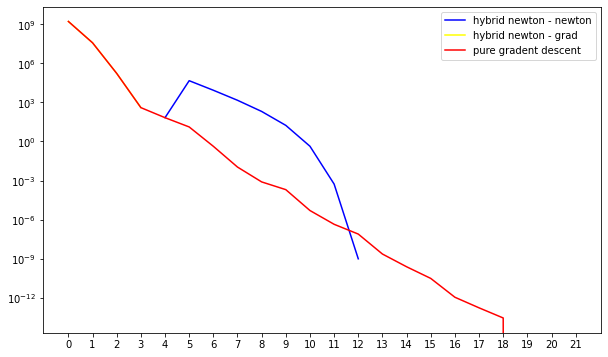

In [128]:
import matplotlib.pyplot as plt

xs = np.arange(len(newton))
xs_newt, xs_grad, fs_newt, fs_grad = [], [], [], []
for i in range(len(newton)):
    if newton[i] ==1:
        xs_newt.append(xs[i]), fs_newt.append(fs[i])
    else:
        xs_grad.append(xs[i]), fs_grad.append(fs[i])

plt.figure(figsize=(10,6))
plt.semilogy(xs_newt, np.array(fs_newt) + 162, label='hybrid newton - newton', color='blue')
plt.semilogy(xs_grad, np.array(fs_grad) + 162, label='hybrid newton - grad', color='yellow')
plt.semilogy(np.arange(len(fs_gen)), np.array(fs_gen) + 162,color='red',label='pure gradent descent')
plt.xticks(np.arange(len(fs_gen)))
plt.legend()
plt.show()